In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os

import cartopy.crs as ccrs
import cartopy.feature as cfeature

%matplotlib inline

#---- declarando as funções que serão utilizadas ao longo do script ----#

def fix_pos(pos):
    """ funcao para corrigir os valores de coordenadas vindos no excel do IBAMA """
    # source: ttps://gist.github.com/ocefpaf/60bec6fbd252107de11073376bad7925
    deg, rest = pos.split("°")
    mi, rest = rest.strip().split("'")
    sec, hem = rest.strip().split('"')
    hem = hem.strip()

    deg, mi, sec = map(float, (deg, mi, sec))
    if hem in ["S", "W"]:
        sign = -1
    elif hem in ["N", "E"]:
        sign = +1
    else:
        raise ValueError(f"Unrecognized sign {sign}, expected 'S', 'W', 'E', or 'N'")

    return sign * (deg + mi/60 + sec/60/60)

###################################################

def make_map(fig=None, ax=None, extent=[-50,-41,-30,-22], projection=ccrs.PlateCarree()):
    """ 
    documente-a como exercício para entender a 
    ação de cada linha
    """
    ax.set_extent(extent, crs=ccrs.PlateCarree())

    coastline_10m = cfeature.NaturalEarthFeature(
        category='physical',name='coastline',scale='10m',
        facecolor=cfeature.COLORS['land'])

    bathy_0m      = cfeature.NaturalEarthFeature(
        category='physical',name='bathymetry_L_0',scale='10m')

    # inserting information over the map
    ax.add_feature(coastline_10m, 
                   edgecolor='black',
                   linewidth=.1)
    ax.add_feature(bathy_0m,
                   facecolor='lightblue',
                   alpha=.3)
    
    return ax

###################################################

def configuring_map(ax, extent):
    # criando as gridlines 
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=.4, color='gray', 
                      alpha=0.5, linestyle='--', 
                      xlocs=np.linspace(extent[0], extent[1], 5),
                      ylocs=np.linspace(extent[3], extent[2], 5))

    gl.top_labels = False
    gl.right_labels = False

    # dicionario com configurações dos rótulos
    dict_style_labels = {
        'color': 'black',
        'fontsize': 8
    }

    gl.ylabel_style = dict_style_labels
    
###################################################

#---- começo do código principal ----#

url = "http://www.ibama.gov.br/phocadownload/emergenciasambientais/2019/manchasdeoleo/2019-12-02_LOCALIDADES_AFETADAS.xlsx"
df = pd.read_excel(
    url,
    parse_dates=["Data_Avist", "Data_Revis"],
)

# Calculando o tempo de permanência da mancha em cada localidade
df["dias"] = (df["Data_Revis"] - df["Data_Avist"]).dt.days

# tratando as colunas de tempo
df['Data_Avist'] = df['Data_Avist'].dt.strftime('%Y-%m-%d').str.replace('NaT', 'na')
df["Data_Revis"] = df["Data_Revis"].dt.strftime("%Y-%m-%d").str.replace("NaT", "na")
df["dias"] = df["dias"].astype(float)

df.dropna(inplace=True)
# um pouco de limpeza de dados (data cleaning)

# removendo linhas onde o status == nao observado
filtr = (df['Status'] == df['Status'].unique()[2])

df = df[~filtr].copy()

# removendo registros onde o dias == 0
filtr = (df['dias'] == 0)
df = df[~filtr].copy()

# necessário tratar as colunas de Latitude e Longitude
df['lat'] = df['Latitude'].apply(fix_pos)
df['lon'] = df['Longitude'].apply(fix_pos)

#----- visualizando -----#
extent = [-45.949, -30, -20, 0] # regiao brasileira

In [ ]:
# 1) Faça um mapa indicando os Estados mais afetados, utilizando como marker='o' (uma bola) e essa bola deve 
# variar de tamanho segundo a quantidade de regiões atingidas apenas.
# Estado mais afetado
states = df.groupby('sigla_uf').count()
states['lat'] = df.groupby('sigla_uf').mean()['lat']
states['lon'] = df.groupby('sigla_uf').mean()['lon']

fig = plt.figure(figsize=(15/2.54,20/2.54)) # em polegadas (tamanho padrão de algumas revistas)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax = make_map(fig=fig, ax=ax, extent=extent, projection=ccrs.PlateCarree())
configuring_map(ax, extent=extent)

ax.scatter(states['lon'].values, states['lat'].values, 
           s=states['Latitude'].values*50,  # o pulo do gato para variar o tamanho dos scatter
           zorder=50)

plt.savefig('lec06_ex01_resposta.png', dpi=150)

In [ ]:
def extrair_info_UF(df, uf='AL'):
    df_por_estado = df[df['sigla_uf'] == uf]
    
    # limites geográficos com base no estado selecionado
    llon,ulon = df_por_estado['lon'].min(), df_por_estado['lon'].max()
    llat,ulat = df_por_estado['lat'].min(), df_por_estado['lat'].max()
    
    extent = [llon-0.05, ulon+0.05, llat-0.02, ulat+0.02]
    
    return df_por_estado, extent

In [ ]:
# Alagoas
alagoas,ext_alagoas = extrair_info_UF(df, uf='AL')
df_alagoas = alagoas.groupby('localidade').cumsum().copy()

fig = plt.figure(figsize=(15/2.54,20/2.54)) # em polegadas (tamanho padrão de algumas revistas)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax = make_map(fig=fig, ax=ax, extent=ext_alagoas, projection=ccrs.PlateCarree())
configuring_map(ax, extent=ext_alagoas)

cf = ax.scatter(df_alagoas['lon'], df_alagoas['lat'],
                s=50, zorder=20,
                c=df_alagoas['dias'])

plt.colorbar(cf)
plt.savefig('lec06_ex02_resposta_alagoas.png', dpi=150)

In [ ]:
# Espirito Santo
estado,ext_estado = extrair_info_UF(df, uf='ES')
df_estado = estado.groupby('localidade').cumsum().copy()

fig = plt.figure(figsize=(15/2.54,20/2.54)) # em polegadas (tamanho padrão de algumas revistas)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax = make_map(fig=fig, ax=ax, extent=ext_estado, projection=ccrs.PlateCarree())
configuring_map(ax, extent=ext_estado)

cf = ax.scatter(df_estado['lon'], df_estado['lat'],
                s=50, zorder=20,
                c=df_estado['dias'])

plt.colorbar(cf)
plt.savefig('lec06_ex02_resposta_espiritosanto.png', dpi=150)

In [ ]:
# 3) Utilize a coluna "dias" do dataframe e refaça o mapa 1), mas agora varie o tamanho dos marcadores 
# segundo o tempo de permanência somado dos Estados. Para isso use o agrupamento do pandas com o método 
# .sum().

# Estado mais afetado
states = df.groupby('sigla_uf').sum()
states['lat'] = df.groupby('sigla_uf').mean()['lat']
states['lon'] = df.groupby('sigla_uf').mean()['lon']

colors = ['']

fig = plt.figure(figsize=(15/2.54,20/2.54)) # em polegadas (tamanho padrão de algumas revistas)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax = make_map(fig=fig, ax=ax, extent=extent, projection=ccrs.PlateCarree())
configuring_map(ax, extent=extent)

ax.scatter(states['lon'].values, states['lat'].values, 
           s=states['dias'].values,  # o pulo do gato para variar o tamanho dos scatter
           zorder=50,
           )

## Campo multidimensionais (nD)

**material de apoio**

- Documentação xarray: [[link]](http://xarray.pydata.org/en/stable/index.html)
- Documentação netcdf4: [[link]](https://unidata.github.io/netcdf4-python/netCDF4/index.html)
- 

**O que são campos multidimensionais?**

Até o momento vimos diversas formas de trabalharmos com séries temporais ou informações unidimensionais. Vamos agora ver um pouco sobre campos multidimensionais, isto é, informações com mais de uma dimensão, podendo ser:

- (tempo,profundidade), 
- (tempo,latitude,longitude),
- (tempo,profundidade,latitude,longitude)
- etc

São tipos de informações muito utilizado por saídas de modelos numéricos (global ou regional), mas também pode observações de satélites, por exemplo. 

Assim, convém entendermos como e com o que analisar tais informações, bem como técnicas para realizar cálculos utilizando matrizes nD de formas simples e computacionalmente otimizadas.

**Formato padrão de armazenamento**

O formato mais padrão de armazenamento de arquivos com dados multidimensionais é o NetCDF, que significa: **Net**work **C**ommon **D**ata **F**ormat.

O grande diferencial deste formato é a utilização combinada de dois antigos formatos de armazenamento de dados: ASCII e binário.

No caso do ASCII, armazenamos as informações utilizando caracteres legíveis para nós, humanos, como no caso de um arquivo ```.dat```, por exemplo, ou em um ```.csv```. No entanto, a facilidade de lermos os dados vem com um custo e este custo é um arquivo mais pesado em termos de armazenamento. No segundo formato, binário, no entanto, armazenamos as informações na linguagem de máquina (0 e 1), reduzindo assim o tamanho do arquivo, porém não podemos interpretar facilmente o que são os dados.

O formato NetCDF vem como uma solução para esta questão. Ele utiliza ambos os formatos em partes distintas do arquivo. 

Informações (atributos) - como metadados (dimensões, instituição que construiu o arquivo, data, etc) - são armazenados utilizando o formato ASCII. Portanto, podemos ter acesso a isso e entender o que o arquivo contem de dados. Enquanto que os dados em si são armazenados em binário, utilizando o poder de compressão de informação deste formato.

In [109]:
!ncdump -h ../dados/nino34_ERA5.nc

netcdf nino34_ERA5 {
dimensions:
	longitude = 201 ;
	latitude = 41 ;
	expver = 2 ;
	time = 500 ;
variables:
	float longitude(longitude) ;
		longitude:units = "degrees_east" ;
		longitude:long_name = "longitude" ;
	float latitude(latitude) ;
		latitude:units = "degrees_north" ;
		latitude:long_name = "latitude" ;
	int expver(expver) ;
		expver:long_name = "expver" ;
	int time(time) ;
		time:units = "hours since 1900-01-01 00:00:00.0" ;
		time:long_name = "time" ;
		time:calendar = "gregorian" ;
	short sst(time, expver, latitude, longitude) ;
		sst:scale_factor = 0.000162757933026109 ;
		sst:add_offset = 298.596354167908 ;
		sst:_FillValue = -32767s ;
		sst:missing_value = -32767s ;
		sst:units = "K" ;
		sst:long_name = "Sea surface temperature" ;

// global attributes:
		:Conventions = "CF-1.6" ;
		:history = "2020-09-30 21:02:53 GMT by grib_to_netcdf-2.16.0: /opt/ecmwf/eccodes/bin/grib_to_netcdf -S param -o /cache/data3/adaptor.mars.internal-1601499573.25794-28066-9-4d805da6-89b7-450e-

**Leitura de arquivos netcdf no python**

Existem, atualmente, dois pacotes para leitura de arquivos netcdf no python: netcdf e xarray.

O primeiro, clássico e utilizado por muitos anos, vem sendo substituído pelo xarray, um pacote relativamente recente. Isto porquê o pacote ```netcdf4``` faz a leitura dos arquivos e cria matrizes, enquanto que o segundo, apresenta uma nova forma de analisar os dados destas informações, nos fornecendo um poderio extra em termos de análise de dados.

### Xarray

A estrutura de dados fornecida pelo ```numpy``` nos permite trabalhar com dados de forma bruta. No entanto, em diversos campos da ciência, o dado não se resume a apenas números. Precisamos compartilhar informações importantes, como vimos os metadados. Estas informações podem, e muitas vezes irão, influenciar a forma como analisamos os dados, seja compreendendo a região de um mapa de temperatura e sua unidade, ou acessando as informações históricas de um determinado conjunto de dados (tratamento de uma série temporal, por exemplo).

![](http://xarray.pydata.org/en/stable/_images/dataset-diagram.png)

No caso de campos multidimensionais **rotulados** (labeled), podemos entender que cada variável ou dimensão terá um nome e atributos associados, que explicarão o que cada informação é.

Usando o exemplo da figura acima, portanto, entendemos que a variável **temperatura** contém seu nome, além de atributos que vão nos prover informações, como unidade, nome completo, alguma convenção, etc.

Veremos mais a frente na prática, mas se estivéssemos utilizando matrizes do numpy, não poderíamos nomear as dimensões da matriz, podendo acessa-las apenas por números (índices).

### O que é o Xarray?

Trata-se de um pacote inspirado no poder do pandas, mas aplicando à matrizes nD. Ele é construído com base no Numpy, matplotlib, cartopy e pandas, além de utilizar o Dask para processamento paralelizado.

Temos, com o xarray, a introdução de duas novas estruturas de dados, similares ao pandas, mas para os campos multidimensionais:

- ```xr.DataArray()```

Matriz multidimensional com dimensões nomeadas. Contém as dimensões, coordenadas e atributos da matriz. Basicamente é um dado com muitos metadados.

- ```xr.Dataset()```

Coleção de matrizes multidimensionais com dimensões alinhadas (iguais).



**Algumas definições/métodos**

- ```.coords``` (coordenadas)

Trata-se de uma matriz, geralmente 1D, que nomeia uma coordenada específica de um ```DataArray```. Existem dois tipos de matrizes de coordendas:

    - _dimension coordinates_ 
    - _non-dimension coordinates_

Podemos entendê-las como "ticklabels" e veremos o porquê mais a frente.

- ```.attrs``` (atributos)

É um dicionário contendo atributos arbitrários.

Vamos começar a explorar o pacote ```xarray``` fazendo um pequeno comparativo em termos de processamento com o pacote ```netcdf4```.

In [2]:
# importando os dois pacotes
import netCDF4 as nc
import xarray as xr

# para ler um arquivo em cada pacote:
data_nc = nc.Dataset('/home/danilo/DATA/ERA5/SSTreanalysis/atlantic_sst2.nc')
data_xr = xr.open_dataset('/home/danilo/DATA/ERA5/SSTreanalysis/atlantic_sst2.nc')

# comparar o tipo
type(data_nc), type(data_xr)

(netCDF4._netCDF4.Dataset, xarray.core.dataset.Dataset)

Conhecendo a cara do que cada pacote nos traz:

In [3]:
data_nc

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    Conventions: CF-1.6
    history: 2020-10-06 20:15:49 GMT by grib_to_netcdf-2.16.0: /opt/ecmwf/eccodes/bin/grib_to_netcdf -S param -o /cache/data3/adaptor.mars.internal-1602015108.4814277-3451-1-61049aaf-bf82-4cd2-8423-d4e1bc7df3f4.nc /cache/tmp/61049aaf-bf82-4cd2-8423-d4e1bc7df3f4-adaptor.mars.internal-1602015108.4833565-3451-1-tmp.grib
    dimensions(sizes): longitude(277), latitude(193), expver(2), time(501)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 expver(expver), int32 time(time), int16 sst(time, expver, latitude, longitude)
    groups: 

In [4]:
data_nc.variables

{'longitude': <class 'netCDF4._netCDF4.Variable'>
 float32 longitude(longitude)
     units: degrees_east
     long_name: longitude
 unlimited dimensions: 
 current shape = (277,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'latitude': <class 'netCDF4._netCDF4.Variable'>
 float32 latitude(latitude)
     units: degrees_north
     long_name: latitude
 unlimited dimensions: 
 current shape = (193,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'expver': <class 'netCDF4._netCDF4.Variable'>
 int32 expver(expver)
     long_name: expver
 unlimited dimensions: 
 current shape = (2,)
 filling on, default _FillValue of -2147483647 used,
 'time': <class 'netCDF4._netCDF4.Variable'>
 int32 time(time)
     units: hours since 1900-01-01 00:00:00.0
     long_name: time
     calendar: gregorian
 unlimited dimensions: 
 current shape = (501,)
 filling on, default _FillValue of -2147483647 used,
 'sst': <class 'netCDF4._netCDF4.Variable'>
 int16 sst(time, expver, lat

In [5]:
data_xr

<xarray.Dataset>
Dimensions:    (expver: 2, latitude: 193, longitude: 277, time: 501)
Coordinates:
  * longitude  (longitude) float32 -60.0 -59.75 -59.5 -59.25 ... 8.5 8.75 9.0
  * latitude   (latitude) float32 24.0 23.75 23.5 23.25 ... -23.5 -23.75 -24.0
  * expver     (expver) int32 1 5
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-09-01
Data variables:
    sst        (time, expver, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-10-06 20:15:49 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

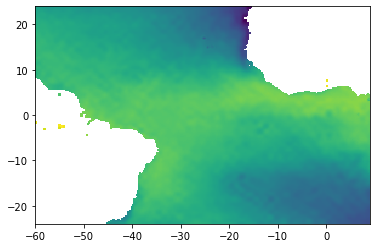

In [6]:
lon = data_nc['longitude'][:]
lat = data_nc['latitude'][:]
sst = data_nc['sst'][0,0,:,:]

plt.figure()
plt.pcolormesh(lon, lat, sst)

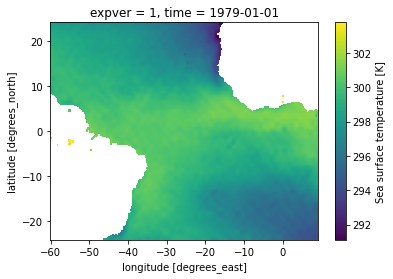

In [7]:
data_xr.isel(time=0, expver=0)['sst'].plot.pcolormesh()

Com poucas linhas, construímos uma figura de SST, já customizada com barra de cores, ticklabels (perceba as ```coords```).

O pacote ```netCDF4``` ainda é utilizado por muitos pacotes python e sua utilização é relativamente simple. Aos poucos a comunidade tem migrado para utilização do ```xarray``` e daremos um enfoque a este a partir de agora. 

In [8]:
ds = xr.open_dataset('/home/danilo/DATA/ERA5/SSTreanalysis/atlantic_sst2.nc')

**Acessando atributos:** ```.attrs()```

Funciona tanto para dados (variáveis), quanto para coordenadas e dimensões.

In [56]:
ds['sst'].attrs

{'units': 'K', 'long_name': 'Sea surface temperature'}

In [57]:
ds.coords['longitude'].attrs

{'units': 'degrees_east', 'long_name': 'longitude'}

In [61]:
ds.time.attrs

{'long_name': 'time'}

### Extraindo dados por indexamento

Herda as regras de indexação do pandas, ou seja, ótimo suporte para datas e horas.


**Label-based indexing**: .sel()

Métodos de seleção de dados utilizando dimensões e coordenadas.

In [67]:
# selecionar registros para um ano específico
ds.sel(time='2010')

In [71]:
# selecionar uma coordenada específica, utilizando o método do
# mais próximo. 
ds.sel(longitude=-40, latitude=-30, method='nearest')

In [73]:
# Note que sem o método 'nearest', não é encontrado nenhum  valor
ds.sel(longitude=-40, latitude=-30)

In [78]:
# selecionando tempo com o comando slice (recorte)
ds.sel(time=slice('2010','2019'))

**Position-based indexing**: .isel()

Usa-se a posição (índice), em número inteiro, de uma informação. Este índice é referente à matriz 1D de coordenada ou dimensão criada na estrutura.

In [82]:
# seleção com base no
ds.isel(time=0, expver=0)['sst']

In [84]:
# seleção de uma coordenada pelo índice desta na coordenada referente
ds.isel(longitude=10, latitude=10)

### Cálculos de alto nível

Temos disponíveis métodos similares, em objetivo, aos do Pandas. Porém, precisamos nos atentar às dimensões que escolhemos para realizar os cálculos.


- **Groupby:** agrupamento de informações por chaves (grupos). Altamente utilizado para computar, em conjuntos de dados longos, médias sazonais, mensais, etc.


- **Resample:** aplica-se uma reamostragem seguindo uma estatística enviada.


- **Rolling:** estatística móvel aplicada em uma dimensão. Note que a janela utilizada deve ser coerente com a frequência dos seus dados. Ou seja: para um dataset com frequência temporal mensal, uma janela de 3 implica em 3 meses.

In [27]:
# agrupamento temporal por ano, aplica-se a média
ds.groupby('time.year').mean()

<xarray.Dataset>
Dimensions:    (expver: 2, latitude: 193, longitude: 277, year: 42)
Coordinates:
  * longitude  (longitude) float32 -60.0 -59.75 -59.5 -59.25 ... 8.5 8.75 9.0
  * latitude   (latitude) float32 24.0 23.75 23.5 23.25 ... -23.5 -23.75 -24.0
  * expver     (expver) int32 1 5
  * year       (year) int64 1979 1980 1981 1982 1983 ... 2017 2018 2019 2020
Data variables:
    sst        (year, expver, latitude, longitude) float32 299.23422 ... 290....

In [10]:
# agrupamento temporal por estação do ano, aplica-se a média
ds.groupby('time.season').mean()

<xarray.Dataset>
Dimensions:    (expver: 2, latitude: 193, longitude: 277, season: 4)
Coordinates:
  * longitude  (longitude) float32 -60.0 -59.75 -59.5 -59.25 ... 8.5 8.75 9.0
  * latitude   (latitude) float32 24.0 23.75 23.5 23.25 ... -23.5 -23.75 -24.0
  * expver     (expver) int32 1 5
  * season     (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    sst        (season, expver, latitude, longitude) float32 298.2522 ... 290...

In [28]:
# reamostragem de mensal para anual, aplica-se a média
ds.resample(time='Y').mean()

<xarray.Dataset>
Dimensions:    (expver: 2, latitude: 193, longitude: 277, time: 42)
Coordinates:
  * time       (time) datetime64[ns] 1979-12-31 1980-12-31 ... 2020-12-31
  * longitude  (longitude) float32 -60.0 -59.75 -59.5 -59.25 ... 8.5 8.75 9.0
  * latitude   (latitude) float32 24.0 23.75 23.5 23.25 ... -23.5 -23.75 -24.0
  * expver     (expver) int32 1 5
Data variables:
    sst        (time, expver, latitude, longitude) float32 299.23422 ... 290....

In [29]:
# média móvel de 3 meses
ds.rolling(time=3).mean()

<xarray.Dataset>
Dimensions:    (expver: 2, latitude: 193, longitude: 277, time: 501)
Coordinates:
  * longitude  (longitude) float32 -60.0 -59.75 -59.5 -59.25 ... 8.5 8.75 9.0
  * latitude   (latitude) float32 24.0 23.75 23.5 23.25 ... -23.5 -23.75 -24.0
  * expver     (expver) int32 1 5
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-09-01
Data variables:
    sst        (time, expver, latitude, longitude) float32 nan nan ... nan nan

# Cálculo do Índice do El Niño 3.4

Exemplo adaptado do tutorial fornecido pelo NCAR [[aqui]](https://ncar.github.io/PySpark4Climate/tutorials/Oceanic-Ni%C3%B1o-Index/#Computational-Recipe)

Receita:

- média espacial na região do Niño 3.4 (ponderada pela lat/lon)
- cálculo da climatologia mensal
- cálculo da anomalia da média espacial
- média móvel de 3 meses para suavização

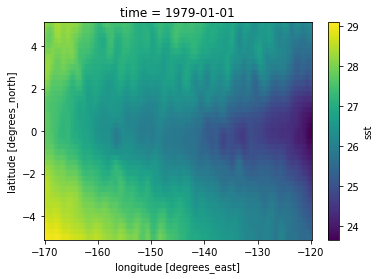

In [82]:
# leitura de arquivos ERA5
ds = xr.open_dataset('../dados/nino34.nc')
ds = ds.mean(dim='expver')

# converter de Kelvin para oC
ds['sst'] -= 273.15

ds.isel(time=0).sst.plot.pcolormesh()

In [83]:
def global_mean_sst(dset):
    # source: https://ncar.github.io/PySpark4Climate/tutorials/Oceanic-Ni%C3%B1o-Index/#Computational-Recipe
    # Find mean temperature for each latitude
    mean_sst_lat = dset.sst.mean(dim='longitude')

    # Find Weighted mean of those values
    num =(np.cos(dset.latitude) * mean_sst_lat).sum(dim='latitude')
    denom = np.sum(np.cos(dset.latitude))

    # Find mean global temperature
    mean_global_temp = num / denom

    return mean_global_temp

In [84]:
# média espacial ingênua, necessário ponderar pela coordenadas,
# pois a variação de lat/lon implica em uma área diferente
ds_avg_1 = ds.mean(dim=['latitude', 'longitude'])
ds_avg_2 = global_mean_sst(ds)

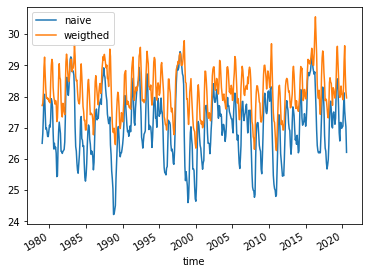

In [86]:
# diferença entre os dois tipos de média espacial
fig,ax = plt.subplots()

ds_avg_1.sst.plot(ax=ax, label='naive')

ds_avg_2.plot(ax=ax, label='weigthed')

plt.legend()

In [87]:
# climatologia utilizando groupby
ds_clim = ds_avg_2.groupby('time.month').mean('time')
ds_clim

<xarray.DataArray (month: 12)>
array([27.58899 , 27.711615, 28.212307, 28.805485, 29.040966, 28.839216,
       28.489313, 28.05299 , 27.850655, 27.899649, 27.9292  , 27.74933 ],
      dtype=float32)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

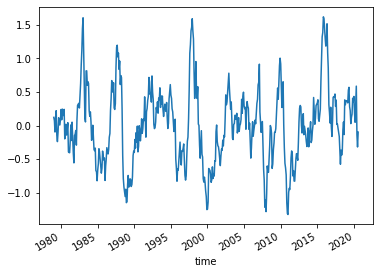

In [91]:
# anomalia espacial utilizando o groupby sem método estatístico
ds_anom = ds_avg_2.groupby('time.month') - ds_clim

ds_anom.plot()

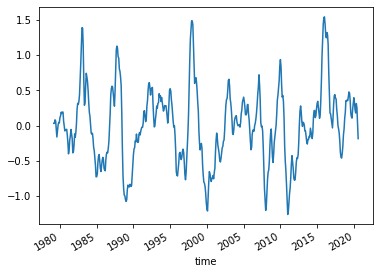

In [106]:
# suavização com média móvel de 3 meses para calcular o 
# Oceanic Nino Index (ONI)
ds_oni = ds_anom.rolling(time=3).mean()

ds_oni.plot()